# Introduction

This is a demo project for loading and exploring a set of transaction data released by Capital One. <br>
The following steps should be taken: <br>
<ol>
    <li>Loading and exploring data</li>
    Check the shape of the data, missing values, data type, etc. And modify them if necessary.
    <li>Visualizing data</li>
    Quickly plotting the data can help us better understand.
    <li>Data wrangling</li>
    Find the duplicate transactions and have more insights
    <li>Modeling and evaluating</li>
</ol>

## Loading data
Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found at https://github.com/CapitalOneRecruiting/DS

In [1]:
# load libraries
import requests, zipfile, io
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = 'https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip'
r = requests.get(path)
with zipfile.ZipFile(io.BytesIO(r.content)) as myzip:
    with myzip.open('transactions.txt') as myfile:
        df = pd.DataFrame([json.loads(line) for line in myfile])

display(df.shape, df.head(2))

(786363, 29)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False


The data is in a txt file, each row contains information on one transaction in json format.

In [3]:
print('There are %7d records and there are %3d fields in each record' % (df.shape[0], df.shape[1]))

There are  786363 records and there are  29 fields in each record


Take a glimpse on the data:

In [4]:
print("First 8 columns of top 5 records.")
df[df.columns[:8]].head()

First 8 columns of top 5 records.


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US


In [5]:
print("Second 8 columns of top 5 records.")
df[df.columns[8:16]].head()

Second 8 columns of top 5 records.


,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV
0,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414
1,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486
2,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486
3,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486
4,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885


In [6]:
print("Third 8 columns of top 5 records.")
df[df.columns[16:24]].head()

Third 8 columns of top 5 records.


,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip
0,414,1803,PURCHASE,,0.0,,,
1,486,767,PURCHASE,,0.0,,,
2,486,767,PURCHASE,,0.0,,,
3,486,767,PURCHASE,,0.0,,,
4,885,3143,PURCHASE,,0.0,,,


In [7]:
print("Last 5 columns of top 5 records.")
df[df.columns[24:]].head()

Last 5 columns of top 5 records.


,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,False,,,False,False
1,True,,,False,False
2,False,,,False,False
3,False,,,False,False
4,True,,,False,False


it seems all the NA values are stored as empty strings, so we will replace them with np.nan and check their statistic

In [8]:
# this is an example of missing value, which is an empty string here.
df['posOnPremises'].values[0]

''

In [9]:
# replace the empty strings with numpy missing values.
df.replace('', np.nan, inplace=True)
# how many missing values in each column
df.isnull().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

Note that in some columns, e.g. merchantCity and merchantState, all values are missed (# of missing values = # of records, 786363). These columns should be dropped later.

Let's check the data types of all fields. Convert them to their appropriate column types

In [10]:
for col in ['accountNumber', 'cardCVV','cardLast4Digits','enteredCVV']:
    df[col] = df[col].astype(int)
    
for col in ['accountOpenDate','dateOfLastAddressChange']:
    df[col] = pd.to_datetime(df[col], format = "%Y-%M-%d")
    
for col in ['currentExpDate']:
    df[col] = pd.to_datetime(df[col], format = "%M/%Y")
    
for col in ['transactionDateTime']:
    df[col] = pd.to_datetime(df[col], format = "%Y-%m-%dT%H:%M:%S")
    
for col in ['merchantCategoryCode', 'posConditionCode','posEntryMode','transactionType','posEntryMode']:
    df[col] = df[col].astype('category')

In [11]:
df.dtypes

accountNumber                        int32
customerId                          object
creditLimit                        float64
availableMoney                     float64
transactionDateTime         datetime64[ns]
transactionAmount                  float64
merchantName                        object
acqCountry                          object
merchantCountryCode                 object
posEntryMode                      category
posConditionCode                  category
merchantCategoryCode              category
currentExpDate              datetime64[ns]
accountOpenDate             datetime64[ns]
dateOfLastAddressChange     datetime64[ns]
cardCVV                              int32
enteredCVV                           int32
cardLast4Digits                      int32
transactionType                   category
echoBuffer                         float64
currentBalance                     float64
merchantCity                       float64
merchantState                      float64
merchantZip

In [12]:
# drop the columns in which all values are missed
df = df[[col for col in df.columns if df[col].isna().sum() != df.shape[0]]]

In [13]:
n = 0
while df.shape[1] - n >=8:
    display(df.iloc[:5, n:n+8])
    n+=8
if n < df.shape[1]:
    display(df.iloc[:5, n:])

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US


,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV
0,US,02,01,rideshare,2023-01-01 00:06:00,2015-01-14 00:03:00,2015-01-14 00:03:00,414
1,US,09,01,entertainment,2024-01-01 00:02:00,2015-01-14 00:03:00,2015-01-14 00:03:00,486
2,US,09,01,mobileapps,2025-01-01 00:08:00,2015-01-14 00:03:00,2015-01-14 00:03:00,486
3,US,09,01,mobileapps,2025-01-01 00:08:00,2015-01-14 00:03:00,2015-01-14 00:03:00,486
4,US,02,01,fastfood,2029-01-01 00:10:00,2015-01-06 00:08:00,2015-01-06 00:08:00,885


,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,414,1803,PURCHASE,0.0,False,False,False
1,486,767,PURCHASE,0.0,True,False,False
2,486,767,PURCHASE,0.0,False,False,False
3,486,767,PURCHASE,0.0,False,False,False
4,885,3143,PURCHASE,0.0,True,False,False


### Additional basic summary statistics for each field, including a count of null, minimum, maximum, and unique values where appropriate.

In [14]:
categorical_columns = ['accountNumber','cardCVV','cardLast4Digits','enteredCVV','acqCountry','cardPresent','customerId',
                      'enteredCVV','expirationDateKeyInMatch','isFraud','merchantCategoryCode','transactionType']
for col in categorical_columns:
    print(col)
    na_count, unique_count = df[col].isnull().sum(), len(set(df[col]))
    print("There are %5d number of NA values" % na_count)
    print("There are %5d number of unique values" % unique_count)
    if unique_count < 20:
        print("top 5 values are: ")
        print(df[col].value_counts()[:5])
    print()

accountNumber
There are     0 number of NA values
There are  5000 number of unique values

cardCVV
There are     0 number of NA values
There are   899 number of unique values

cardLast4Digits
There are     0 number of NA values
There are  5245 number of unique values

enteredCVV
There are     0 number of NA values
There are   976 number of unique values

acqCountry
There are  4562 number of NA values
There are     5 number of unique values
top 5 values are: 
US     774709
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

cardPresent
There are     0 number of NA values
There are     2 number of unique values
top 5 values are: 
False    433495
True     352868
Name: cardPresent, dtype: int64

customerId
There are     0 number of NA values
There are  5000 number of unique values

enteredCVV
There are     0 number of NA values
There are   976 number of unique values

expirationDateKeyInMatch
There are     0 number of NA values
There are     2 number of unique values


In [15]:
continous_columns = ['availableMoney','creditLimit','currentBalance','accountOpenDate','currentExpDate',
                     'dateOfLastAddressChange','transactionAmount']
for col in continous_columns:
    print(col, ":")
    print("There are %5d number of NA values" % df[col].isnull().sum())
    print("minimum value is: ", df[col].min())
    print("maxmium value is: ", df[col].max())
    if "date" not in col.lower():
        print("median  value is: ", df[col].median())
        print("mean    value is: ", df[col].mean())
    print()

availableMoney :
There are     0 number of NA values
minimum value is:  -1005.63
maxmium value is:  50000.0
median  value is:  3184.86
mean    value is:  6250.725369288736

creditLimit :
There are     0 number of NA values
minimum value is:  250.0
maxmium value is:  50000.0
median  value is:  7500.0
mean    value is:  10759.464458526152

currentBalance :
There are     0 number of NA values
minimum value is:  0.0
maxmium value is:  47498.81
median  value is:  2451.76
mean    value is:  4508.7390892374115

accountOpenDate :
There are     0 number of NA values
minimum value is:  1989-01-22 00:08:00
maxmium value is:  2015-01-31 00:12:00

currentExpDate :
There are     0 number of NA values
minimum value is:  2019-01-01 00:12:00
maxmium value is:  2033-01-01 00:08:00

dateOfLastAddressChange :
There are     0 number of NA values
minimum value is:  1989-01-22 00:08:00
maxmium value is:  2016-01-31 00:10:00

transactionAmount :
There are     0 number of NA values
minimum value is:  0.0
maxmi

## Visualizing data

Plot a histogram of the processed amounts of each transaction, the transactionAmount column.

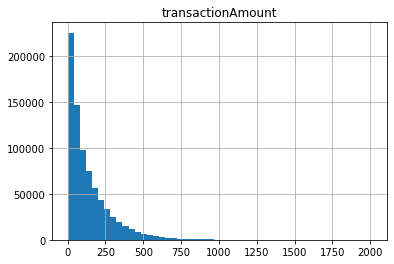

In [16]:
df.hist(column='transactionAmount', bins=50)
plt.show()

The plot is concentrated to the left. Let us zoom in.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002E04A4F29C8>]],
      dtype=object)

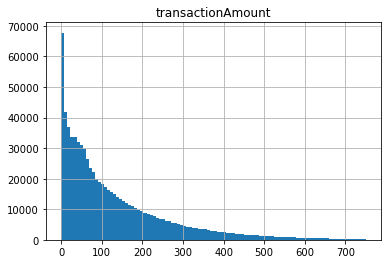

In [17]:
df[df['transactionAmount'] < 750].hist(column='transactionAmount', bins=100)

### Report any structure you find and any hypotheses you have about that structure.
There is a big peak near 0. This might due to a large amount of zero dollar transactions (address verification for example). The general shape looks like a power-law or exponential decay. We can try to fit the histogram by power_law or exponential decay and see which one describes the data better.

## Question 3: Data Wrangling - Duplicate Transactions
You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span. Another example is a reversed transaction, where a purchase is followed by a reversal.

Can you programmatically identify duplicated and reversed transactions?

Did you find anything interesting about either of these transaction types?

What share of transactions (both number of transactions and the dollar amount) do you estimate for the duplicated and reversed transaction types that you identified? In a multi-swipe transaction, please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts.

In [18]:
count_id, count_duplicates, count_reversals, count_subscriptons,count_transactions = 0, 0, 0, 0, 0
dollar_duplicates, dollar_reversals, dollar_total = 0, 0, 0
print_details = True
for pid, df_per_id in df.groupby(['accountNumber']):  # group by account number
    count_id += 1
    if count_id % 1000 == 5: print("The number of accounts processed", count_id)
    dollar_total += df_per_id['transactionAmount'].sum()
    count_transactions += df_per_id.shape[0]
    for group, df_per_per_category in df_per_id.groupby(['merchantName','transactionAmount']): 
        # candidates for reversal/duplicates transactions if merchantname and amount are the same
        if df_per_per_category.shape[0] > 1:
            if df_per_per_category.at[df_per_per_category.index[-1], 'transactionType'] == 'REVERSAL':
                count_reversals += 1
                dollar_reversals += group[1]
                if df_per_per_category.shape[0] > 3 and print_details:
                    # this invloves both reversal and duplicated transactions and is rare ( so they are ignored for now)
                    print("This is an example of both reversal and other things")
                    print("accountID", pid, group,count_id)
                    print(df_per_per_category[['transactionDateTime','availableMoney','isFraud','transactionType']])
                    print()
                if count_reversals % 100 == 5 and print_details:
                    print("This is an example of REVERSALS:")
                    print("accountID", pid, group,count_id)
                    print(df_per_per_category[['transactionDateTime','availableMoney','isFraud','transactionType']])
                    print()
            elif len(set(df_per_per_category['transactionDateTime'].apply(lambda x: x.day))) == 1:
            # all transactions happened on the same day
                count_duplicates += 1
                dollar_duplicates += (df_per_per_category.shape[0] - 1) * group[1]
                if  count_duplicates % 100 == 5 and print_details:
                    print("This is an example of DUPLICATES:")
                    print("accountID", pid, group,count_id)
                    print(df_per_per_category[['transactionDateTime','availableMoney','isFraud','transactionType']])
                    print()
            elif set(df_per_per_category['transactionType']) == set(["PURCHASE"]):
                # this should be periodic transactions
                count_subscriptons += 1
                if count_subscriptons % 100 == 5 and print_details:
                    print("This is an example of periodic subscription:")
                    print("accountID", pid, group,count_id)
                    print(df_per_per_category[['transactionDateTime','availableMoney','isFraud','transactionType']])
                    print()


This is an example of periodic subscription:
accountID 100328049 ('Play Store', 3.33) 3
      transactionDateTime  availableMoney  isFraud transactionType
87964 2016-07-02 18:39:38         5000.00    False        PURCHASE
87970 2016-08-02 07:57:22         4819.61    False        PURCHASE
87980 2016-09-02 23:02:05         4530.69    False        PURCHASE
87990 2016-10-03 09:54:13         5000.00    False        PURCHASE
88003 2016-11-02 21:34:27         4635.78    False        PURCHASE
88010 2016-12-03 22:06:16         4906.83    False        PURCHASE

The number of accounts processed 5
This is an example of REVERSALS:
accountID 100737756 ('Best Bistro #262998', 501.29) 5
       transactionDateTime  availableMoney  isFraud transactionType
151534 2016-08-11 09:20:41          113.90    False        PURCHASE
151541 2016-08-24 20:21:19          144.52    False        REVERSAL

This is an example of DUPLICATES:
accountID 101132326 ('Regal Cinemas #05791', 188.86) 7
       transactionDateTime

This is an example of REVERSALS:
accountID 152973583 ('Krispy Kreme #699812', 96.6) 305
       transactionDateTime  availableMoney  isFraud transactionType
616502 2016-03-11 09:21:34         8368.26    False        PURCHASE
616503 2016-03-11 09:24:20         8271.66    False        REVERSAL

This is an example of periodic subscription:
accountID 152991752 ('Apple iTunes', 3.76) 306
       transactionDateTime  availableMoney  isFraud transactionType
204183 2016-06-22 02:31:40        18079.41    False        PURCHASE
204186 2016-07-23 05:21:47        17743.41    False        PURCHASE
204189 2016-08-22 23:11:44        17345.10    False        PURCHASE
204190 2016-09-23 08:54:22        17366.34    False        PURCHASE
204193 2016-10-24 18:04:29        17280.64    False        PURCHASE
204194 2016-11-24 06:58:31        17301.88    False        PURCHASE
204197 2016-12-25 07:40:17        17262.48    False        PURCHASE

This is an example of DUPLICATES:
accountID 157017952 ('staples.com', 

This is an example of REVERSALS:
accountID 207934176 ('cheapfast.com', 378.39) 623
       transactionDateTime  availableMoney  isFraud transactionType
279196 2016-12-20 04:09:39          996.65    False        PURCHASE
279197 2016-12-21 21:36:27          618.26    False        REVERSAL

This is an example of both reversal and other things
accountID 208319653 ('Ricks Auto Body', 0.0) 625
       transactionDateTime  availableMoney  isFraud       transactionType
533639 2016-01-27 06:46:03        10364.78    False  ADDRESS_VERIFICATION
533891 2016-02-15 03:15:30         1754.46    False  ADDRESS_VERIFICATION
537777 2016-11-11 02:41:02          753.07    False  ADDRESS_VERIFICATION
537778 2016-11-11 02:43:37          753.07    False              REVERSAL

This is an example of REVERSALS:
accountID 208319653 ('sears.com', 146.19) 625
       transactionDateTime  availableMoney  isFraud transactionType
534588 2016-04-02 12:49:39         3746.32    False        PURCHASE
534589 2016-04-02 12:52:

This is an example of REVERSALS:
accountID 265365425 ('discount.com', 553.26) 953
       transactionDateTime  availableMoney  isFraud transactionType
425665 2016-12-05 12:30:09         7500.00    False        PURCHASE
425666 2016-12-12 16:10:09         6946.74    False        REVERSAL

This is an example of REVERSALS:
accountID 269616174 ('gap.com', 144.45) 966
       transactionDateTime  availableMoney  isFraud transactionType
134424 2016-02-03 03:01:51          448.50    False        PURCHASE
134425 2016-02-03 03:02:47          304.05    False        REVERSAL

This is an example of REVERSALS:
accountID 272914249 ("Domino's Pizza #112007", 70.95) 987
       transactionDateTime  availableMoney  isFraud transactionType
321899 2016-12-06 19:04:15         6763.02    False        PURCHASE
321912 2016-12-23 06:35:10         5422.05    False        REVERSAL

This is an example of periodic subscription:
accountID 274242430 ('Sunoco Gas #686950', 52.34) 997
       transactionDateTime  availabl

This is an example of REVERSALS:
accountID 328464921 ('Fresh Flowers', 22.97) 1277
       transactionDateTime  availableMoney  isFraud transactionType
546226 2016-07-30 17:02:33         1189.98    False        PURCHASE
546227 2016-07-30 17:02:40         1167.01    False        REVERSAL

This is an example of DUPLICATES:
accountID 330133277 ('Golds Gym #364682', 109.87) 1286
       transactionDateTime  availableMoney  isFraud transactionType
238771 2016-10-02 11:50:46          413.14    False        PURCHASE
238772 2016-10-02 11:53:11          303.27    False        PURCHASE

This is an example of REVERSALS:
accountID 334447661 ('Virgin Airlines', 101.25) 1308
       transactionDateTime  availableMoney  isFraud transactionType
474745 2016-01-29 00:38:33         4279.43    False        PURCHASE
474781 2016-02-11 07:19:48        10515.93    False        REVERSAL

This is an example of periodic subscription:
accountID 339917982 ('abc.com', 18.26) 1329
       transactionDateTime  availableM

This is an example of both reversal and other things
accountID 380680241 ('Blue Mountain Online Services', 86.61) 1558
       transactionDateTime  availableMoney  isFraud transactionType
259083 2016-07-28 08:43:04         1697.91    False        PURCHASE
259084 2016-07-28 08:43:35         1611.30    False        PURCHASE
259705 2016-08-04 11:59:41         1372.59    False        PURCHASE
261889 2016-08-29 04:43:04         1167.30    False        REVERSAL

This is an example of periodic subscription:
accountID 380680241 ('Blue Mountain Online Services', 151.67) 1558
       transactionDateTime  availableMoney  isFraud transactionType
251204 2016-05-01 05:35:42          1584.5    False        PURCHASE
255896 2016-06-22 20:15:03          2531.8    False        PURCHASE

This is an example of DUPLICATES:
accountID 380680241 ('Blue Mountain Online Services', 182.8) 1558
       transactionDateTime  availableMoney  isFraud transactionType
248409 2016-03-31 09:07:18         1544.71    False    

This is an example of REVERSALS:
accountID 380680241 ('Next Day Online Services', 56.32) 1558
       transactionDateTime  availableMoney  isFraud transactionType
257291 2016-07-08 11:27:17         2212.68    False        PURCHASE
258330 2016-07-20 00:15:20         3364.83    False        REVERSAL

This is an example of periodic subscription:
accountID 380680241 ('Next Day Online Services', 57.83) 1558
       transactionDateTime  availableMoney  isFraud transactionType
255770 2016-06-21 10:15:02         1593.32    False        PURCHASE
270632 2016-12-04 06:21:24         3720.29     True        PURCHASE

This is an example of periodic subscription:
accountID 380680241 ('Next Day eCards', 2.57) 1558
       transactionDateTime  availableMoney  isFraud transactionType
242407 2016-01-25 05:22:22         1385.34    False        PURCHASE
265842 2016-10-12 22:18:14         2769.16    False        PURCHASE

This is an example of periodic subscription:
accountID 380680241 ('Next Day eCards', 66.9

This is an example of periodic subscription:
accountID 410667672 ('Play Store', 6.38) 1733
       transactionDateTime  availableMoney  isFraud transactionType
434688 2016-09-19 14:09:22          585.85    False        PURCHASE
434714 2016-10-20 10:34:54         2576.44    False        PURCHASE
434735 2016-11-19 12:11:29         5129.90    False        PURCHASE
434759 2016-12-21 05:05:13         2541.41    False        PURCHASE

This is an example of REVERSALS:
accountID 414225870 ('AMC #706324', 209.18) 1751
       transactionDateTime  availableMoney  isFraud transactionType
407134 2016-06-02 21:49:48         2810.37    False        PURCHASE
407137 2016-06-16 05:30:01         2212.61    False        REVERSAL

This is an example of REVERSALS:
accountID 419709514 ('amazon.com', 35.97) 1780
       transactionDateTime  availableMoney  isFraud transactionType
428257 2016-04-13 14:47:50         3172.35    False        PURCHASE
428258 2016-04-13 14:48:31         3136.38    False        REVERS

This is an example of REVERSALS:
accountID 471569388 ('ebay.com', 108.01) 2083
       transactionDateTime  availableMoney  isFraud transactionType
151370 2016-11-07 04:16:05         1000.00    False        PURCHASE
151371 2016-11-07 04:16:06          891.99    False        REVERSAL

This is an example of both reversal and other things
accountID 472288969 ('Icelandic Airlines', 0.0) 2085
       transactionDateTime  availableMoney  isFraud       transactionType
698351 2016-01-14 05:17:51         5044.43    False  ADDRESS_VERIFICATION
698413 2016-01-27 06:26:47         2287.07    False  ADDRESS_VERIFICATION
698768 2016-04-08 20:33:55         5622.99    False  ADDRESS_VERIFICATION
698815 2016-04-19 16:52:56         1570.22    False  ADDRESS_VERIFICATION
698990 2016-05-26 19:37:28         2131.57    False  ADDRESS_VERIFICATION
698991 2016-05-26 19:40:05         2131.57    False              REVERSAL
699316 2016-08-03 02:15:24         9226.65    False  ADDRESS_VERIFICATION
699623 2016-10-03 

This is an example of both reversal and other things
accountID 527298269 ('Washington Auto Body', 175.39) 2369
       transactionDateTime  availableMoney  isFraud transactionType
669814 2016-09-04 16:23:18        14410.73    False        PURCHASE
669815 2016-09-04 16:25:34        14235.34    False        PURCHASE
669816 2016-09-04 16:28:07        14059.95    False        PURCHASE
669856 2016-10-04 05:06:53        13769.99    False        REVERSAL

This is an example of DUPLICATES:
accountID 527298269 ('Washington Repair', 149.25) 2369
       transactionDateTime  availableMoney  isFraud transactionType
669876 2016-10-17 04:50:59        11021.54    False        PURCHASE
669877 2016-10-17 04:52:01        10872.29    False        PURCHASE

This is an example of REVERSALS:
accountID 529506600 ('Uber', 13.69) 2375
       transactionDateTime  availableMoney  isFraud transactionType
449646 2016-10-09 13:55:31         3830.48    False        PURCHASE
449647 2016-10-09 13:58:22         3816.79  

This is an example of both reversal and other things
accountID 589624187 ('sears.com', 0.0) 2702
       transactionDateTime  availableMoney  isFraud       transactionType
599760 2016-03-10 04:12:31        31678.62    False  ADDRESS_VERIFICATION
599970 2016-07-08 19:40:01        24145.90    False  ADDRESS_VERIFICATION
600035 2016-08-17 07:57:26        16644.71    False  ADDRESS_VERIFICATION
600045 2016-08-23 21:29:41        15362.63    False              REVERSAL

This is an example of REVERSALS:
accountID 593386671 ('discount.com', 55.73) 2719
       transactionDateTime  availableMoney  isFraud transactionType
236641 2016-07-27 13:13:49        18294.96    False        PURCHASE
236661 2016-08-22 00:37:16        16953.79    False        REVERSAL

This is an example of DUPLICATES:
accountID 594736461 ('West End Beauty #02340', 18.6) 2731
       transactionDateTime  availableMoney  isFraud transactionType
121639 2016-05-05 12:38:10         4134.24    False        PURCHASE
121640 2016-05-05

This is an example of REVERSALS:
accountID 655415336 ('Uber', 83.23) 3078
       transactionDateTime  availableMoney  isFraud transactionType
416178 2016-10-06 00:49:29          559.73    False        PURCHASE
416205 2016-10-18 23:23:52         3838.75    False        REVERSAL

This is an example of DUPLICATES:
accountID 655864583 ('1st Sandwitch Bar #396252', 245.39) 3082
       transactionDateTime  availableMoney  isFraud transactionType
458938 2016-04-23 18:04:06         3751.11    False        PURCHASE
458939 2016-04-23 18:05:23         3505.72    False        PURCHASE
458940 2016-04-23 18:07:30         3260.33    False        PURCHASE

This is an example of both reversal and other things
accountID 655864583 ('apple.com', 0.0) 3082
       transactionDateTime  availableMoney  isFraud       transactionType
458695 2016-03-21 07:56:34         6057.98    False  ADDRESS_VERIFICATION
458811 2016-04-08 00:38:18         4138.20    False  ADDRESS_VERIFICATION
459430 2016-06-25 04:37:16      

This is an example of REVERSALS:
accountID 708011039 ('Lyft', 49.3) 3396
       transactionDateTime  availableMoney  isFraud transactionType
684465 2016-09-04 19:29:07          526.08    False        PURCHASE
684466 2016-09-04 19:30:31          476.78    False        REVERSAL

This is an example of REVERSALS:
accountID 713550428 ('apple.com', 64.2) 3415
       transactionDateTime  availableMoney  isFraud transactionType
674691 2016-01-14 10:07:33         50000.0    False        PURCHASE
674692 2016-01-23 13:58:36         49935.8    False        REVERSAL

This is an example of periodic subscription:
accountID 717906249 ('Play Store', 3.05) 3439
       transactionDateTime  availableMoney  isFraud transactionType
344245 2016-05-22 07:07:09        19132.21    False        PURCHASE
344251 2016-06-21 07:16:49        19298.77    False        PURCHASE
344261 2016-07-21 13:46:38        18519.88    False        PURCHASE
344267 2016-08-22 00:12:27        19824.09    False        PURCHASE
344274 2

This is an example of REVERSALS:
accountID 767620004 ('Lyft', 182.51) 3733
       transactionDateTime  availableMoney  isFraud transactionType
328880 2016-10-19 03:49:10          926.05    False        PURCHASE
329155 2016-11-12 17:17:10         1433.01    False        REVERSAL

This is an example of both reversal and other things
accountID 767620004 ('West End Beauty #380339', 0.0) 3733
       transactionDateTime  availableMoney  isFraud       transactionType
326212 2016-03-14 15:51:37         7229.94    False  ADDRESS_VERIFICATION
326945 2016-05-12 08:12:39         2139.55    False  ADDRESS_VERIFICATION
327684 2016-07-11 08:34:08         1422.25    False  ADDRESS_VERIFICATION
327799 2016-07-20 19:27:43         7216.45    False  ADDRESS_VERIFICATION
328893 2016-10-20 07:24:22         5732.06    False  ADDRESS_VERIFICATION
329231 2016-11-18 13:55:40         2820.68    False              REVERSAL

This is an example of REVERSALS:
accountID 767620004 ('alibaba.com', 133.32) 3733
       t

This is an example of both reversal and other things
accountID 810389858 ('discount.com', 4.68) 3986
       transactionDateTime  availableMoney  isFraud transactionType
526350 2016-12-05 07:09:57        13740.50    False        PURCHASE
526351 2016-12-05 07:12:20        13735.82    False        PURCHASE
526352 2016-12-05 07:13:34        13731.14    False        PURCHASE
526385 2016-12-26 22:15:50         9337.60    False        REVERSAL

This is an example of DUPLICATES:
accountID 812757081 ('amazon.com', 23.56) 3994
       transactionDateTime  availableMoney  isFraud transactionType
532177 2016-07-24 05:55:59          347.88    False        PURCHASE
532178 2016-07-24 05:58:01          324.32    False        PURCHASE
532179 2016-07-24 05:59:48          300.76    False        PURCHASE

This is an example of periodic subscription:
accountID 813651441 ('Play Store', 5.5) 4001
       transactionDateTime  availableMoney  isFraud transactionType
633643 2016-02-02 05:44:21         2197.40    

This is an example of REVERSALS:
accountID 868746206 ('walmart.com', 124.13) 4286
       transactionDateTime  availableMoney  isFraud transactionType
628075 2016-02-01 11:44:16        44752.12    False        PURCHASE
628076 2016-02-01 11:47:14        44627.99    False        REVERSAL

This is an example of periodic subscription:
accountID 870646848 ('Sunoco Gas #387323', 32.56) 4295
       transactionDateTime  availableMoney  isFraud transactionType
570044 2016-07-24 13:30:10          226.71    False        PURCHASE
570048 2016-08-06 16:15:48          167.83    False        PURCHASE
570057 2016-08-19 22:52:37          142.59    False        PURCHASE
570062 2016-09-03 19:04:51           35.69    False        PURCHASE
570073 2016-10-02 08:55:43           58.52    False        PURCHASE
570077 2016-10-15 21:55:33          250.00    False        PURCHASE
570095 2016-11-13 03:22:47          250.00    False        PURCHASE
570115 2016-12-23 16:13:42           40.35    False        PURCHASE



This is an example of REVERSALS:
accountID 922349024 ('EZ Putt Putt #69446', 13.07) 4585
       transactionDateTime  availableMoney  isFraud transactionType
708961 2016-12-20 19:51:51        12500.62    False        PURCHASE
708962 2016-12-21 20:58:06        12487.55    False        REVERSAL

This is an example of periodic subscription:
accountID 925656518 ('TMobile Wireless #87304', 62.8) 4604
       transactionDateTime  availableMoney  isFraud transactionType
293787 2016-06-01 18:40:29          584.19    False        PURCHASE
293807 2016-08-30 13:10:00          782.69    False        PURCHASE
293824 2016-11-28 17:22:21          289.62    False        PURCHASE
293828 2016-12-28 15:39:06          193.73    False        PURCHASE

This is an example of DUPLICATES:
accountID 927431083 ("Hardee's #918765", 80.51) 4613
       transactionDateTime  availableMoney  isFraud transactionType
197347 2016-03-18 19:03:08          890.29    False        PURCHASE
197348 2016-03-18 19:05:05          80

This is an example of REVERSALS:
accountID 967735723 ('West End Beauty #469474', 67.68) 4806
       transactionDateTime  availableMoney  isFraud transactionType
185305 2016-05-22 09:09:16         1713.16    False        PURCHASE
185306 2016-05-22 09:10:12         1645.48    False        REVERSAL

This is an example of DUPLICATES:
accountID 967952818 ('South Steakhouse #378389', 789.27) 4810
       transactionDateTime  availableMoney  isFraud transactionType
185642 2016-05-08 13:12:40         7782.94    False        PURCHASE
185643 2016-05-08 13:13:14         6993.67    False        PURCHASE

This is an example of periodic subscription:
accountID 972967969 ('netflix.com', 13.35) 4837
       transactionDateTime  availableMoney  isFraud transactionType
471283 2016-06-09 09:21:47         7278.30    False        PURCHASE
471292 2016-07-10 17:49:04         6860.58    False        PURCHASE
471304 2016-08-11 00:11:22         7159.24    False        PURCHASE
471313 2016-09-10 12:26:49         7

In [19]:
print("The number of                accounts:", count_id)
print("The percentage of duplicated transactions by  count is %5.2f" % (100*count_duplicates/count_transactions))
print("The percentage of duplicated transactions by amount is %5.2f" % (100*dollar_duplicates/dollar_total))
print("The percentage of reversed   transactions by  count is %5.2f" % (100*count_reversals/count_transactions))
print("The percentage of reversed   transactions by amount is %5.2f" % (100*dollar_reversals/dollar_total))

The number of                accounts: 5000
The percentage of duplicated transactions by  count is  0.89
The percentage of duplicated transactions by amount is  1.01
The percentage of reversed   transactions by  count is  2.30
The percentage of reversed   transactions by amount is  2.47


### some insights:
1. reversal transactions: can be found through tranaction type and the corresponding purchase can be found using the same account number, merchant  name and purchase amount.
- duplicated tranactions: can be found if there are multiple tranactions in a single day for the same acoount number, merchant name and purchase amount
- periodic transactions: They look like duplicated transactions but their transactions do not happen within a day, The tranactions dates are perioid (monthly, bi-monthly, weekly etc)

## Question 4: Model
Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).

Provide an estimate of performance using an appropriate sample, and show your work.

Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

### Feature selection

In [20]:
# the below list will contain all appropriate features
features = []

# the below variable will be set as a threshold for determing if a feature is appropriate
# if any category fraud rate is different from overall fraud rate by 10%, it will be selected as a feature
threhold = 0.1

overall_fraud_rate = df['isFraud'].mean() * 100
print("The overall fraud rate is: %5.3f percent " % overall_fraud_rate)

The overall fraud rate is: 1.579 percent 


For categorical columns, we break into categories and select category as feature if the fraud rate in that category is diffent from overall fraud rate. A dummy variable will be created and is appended to feature list

In [21]:
for col in ['merchantCategoryCode', 'posConditionCode','posEntryMode','transactionType',
            'expirationDateKeyInMatch','cardPresent']:
    print(col)
    for group, sub_df in df.groupby(col):
        fraud_rate = sub_df['isFraud'].mean() * 100
        if abs((fraud_rate - overall_fraud_rate)/overall_fraud_rate) > threhold and group:
            col_name = col + "_" + str(group)
            df[col_name] = (df[col] == group)  # generate dummy columns
            features.append(col_name)
            print("group name: %20s, fraud percentage: %5.4f, total number: %10d selected as a feature!" % (group, fraud_rate, sub_df.shape[0]))
        else:
            print("group name: %20s, fraud percentage: %5.4f, total number: %10d" % (group, fraud_rate, sub_df.shape[0]))
    print()


merchantCategoryCode
group name:              airline, fraud percentage: 3.4648, total number:      15412 selected as a feature!
group name:                 auto, fraud percentage: 1.2609, total number:      21651 selected as a feature!
group name:          cable/phone, fraud percentage: 0.0000, total number:       1382 selected as a feature!
group name:        entertainment, fraud percentage: 1.1998, total number:      80098 selected as a feature!
group name:             fastfood, fraud percentage: 0.9577, total number:     112138 selected as a feature!
group name:                 food, fraud percentage: 1.3432, total number:      75490 selected as a feature!
group name:        food_delivery, fraud percentage: 0.0000, total number:       6000 selected as a feature!
group name:                 fuel, fraud percentage: 0.0000, total number:      23910 selected as a feature!
group name:            furniture, fraud percentage: 1.3859, total number:       7432 selected as a feature!
group n

### Some feature engineering

In [22]:
# how many days between transaction date and account open date
df['days_open'] = (df['transactionDateTime'] - df['accountOpenDate']).apply(lambda x: x.days)
df['days_open'].head(3)

0    577
1    636
2    664
Name: days_open, dtype: int64

There are other features we can generate like this, but we will skip it here.  
For continous varibles, we break into 8 pieces (by quantitles) and do exactly the same thing as above 

In [23]:
for continous_col in ['transactionAmount','availableMoney','currentBalance','days_open']:
    print(continous_col)
    for group, sub_df in df.groupby(pd.qcut(df[continous_col], 8)):
        fraud_rate = sub_df['isFraud'].mean() * 100
        if abs((fraud_rate - overall_fraud_rate)/overall_fraud_rate) > threhold:
            col_name = continous_col + "_" + str(group.left) + "_" + str(group.right)
            df[col_name] = df[col].apply(lambda x: x in group)  # generate dummy columns
            features.append(col_name)
            print("group name: %20s, fraud percentage: %5.4f, total number: %10d selected as a feature!" % (group, fraud_rate, sub_df.shape[0]))
        else:
            print("group name: %20s, fraud percentage: %5.4f, total number: %10d" % (group, fraud_rate, sub_df.shape[0]))
    print()

transactionAmount
group name:      (-0.001, 12.69], fraud percentage: 0.4556, total number:      98326 selected as a feature!
group name:       (12.69, 33.65], fraud percentage: 0.6696, total number:      98273 selected as a feature!
group name:        (33.65, 57.1], fraud percentage: 0.9085, total number:      98298 selected as a feature!
group name:         (57.1, 87.9], fraud percentage: 1.1853, total number:      98290 selected as a feature!
group name:       (87.9, 130.77], fraud percentage: 1.5932, total number:      98294
group name:     (130.77, 191.48], fraud percentage: 1.9227, total number:      98297 selected as a feature!
group name:     (191.48, 295.69], fraud percentage: 2.4621, total number:      98290 selected as a feature!
group name:    (295.69, 2011.54], fraud percentage: 3.4356, total number:      98295 selected as a feature!

availableMoney
group name:  (-1005.631, 436.69], fraud percentage: 1.5168, total number:      98298
group name:    (436.69, 1077.42], fraud 

In [24]:
features

['merchantCategoryCode_airline',
 'merchantCategoryCode_auto',
 'merchantCategoryCode_cable/phone',
 'merchantCategoryCode_entertainment',
 'merchantCategoryCode_fastfood',
 'merchantCategoryCode_food',
 'merchantCategoryCode_food_delivery',
 'merchantCategoryCode_fuel',
 'merchantCategoryCode_furniture',
 'merchantCategoryCode_gym',
 'merchantCategoryCode_health',
 'merchantCategoryCode_hotels',
 'merchantCategoryCode_mobileapps',
 'merchantCategoryCode_online_gifts',
 'merchantCategoryCode_online_retail',
 'merchantCategoryCode_online_subscriptions',
 'merchantCategoryCode_personal care',
 'merchantCategoryCode_rideshare',
 'merchantCategoryCode_subscriptions',
 'posConditionCode_08',
 'posConditionCode_99',
 'posEntryMode_02',
 'posEntryMode_05',
 'posEntryMode_09',
 'posEntryMode_90',
 'transactionType_ADDRESS_VERIFICATION',
 'expirationDateKeyInMatch_True',
 'cardPresent_True',
 'transactionAmount_-0.001_12.69',
 'transactionAmount_12.69_33.65',
 'transactionAmount_33.65_57.1',
 '

In [25]:
df.shape

(786363, 64)

### Split data into training and testing

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[features],
                                                    df['isFraud'],
                                                    test_size=0.3,
                                                    random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(550454, 40) (550454,)
(235909, 40) (235909,)


### Build a random forest model with grid search on hyperparameters

In [27]:
# Hyperparameters that will be tested
param_grid = {'n_estimators': [200,500], 'max_depth':[2, 3]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, scoring ='neg_log_loss')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'max_depth': 3, 'n_estimators': 200}


In [28]:
rf_model =  RandomForestClassifier(**grid.best_params_)
# rf_model =  RandomForestClassifier(max_depth = grid.best_params_['max_depth'],
#                                   n_estimators = grid.best_params_['n_estimators'])
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
for col, importance in sorted(zip(X_train.columns,
                                  rf_model.feature_importances_),
                              key=lambda x: -abs(x[1])): 
    print("feature name: %45s, coefficient: %10.6f" % (col, importance))

feature name:                               posEntryMode_05, coefficient:   0.240033
feature name:                               posEntryMode_09, coefficient:   0.174896
feature name:            merchantCategoryCode_online_retail, coefficient:   0.157297
feature name:                              cardPresent_True, coefficient:   0.134702
feature name:                     merchantCategoryCode_fuel, coefficient:   0.044457
feature name:                  merchantCategoryCode_airline, coefficient:   0.041702
feature name:             merchantCategoryCode_online_gifts, coefficient:   0.040615
feature name:                 merchantCategoryCode_fastfood, coefficient:   0.033855
feature name:                merchantCategoryCode_rideshare, coefficient:   0.030739
feature name:               merchantCategoryCode_mobileapps, coefficient:   0.020063
feature name:          transactionType_ADDRESS_VERIFICATION, coefficient:   0.013656
feature name:                               posEntryMode_02, coef

In [30]:
y_preb = rf_model.predict(X_test)
print("Accuracy", round(metrics.accuracy_score(y_test, y_preb) * 100, 2), "%")

Accuracy 98.44 %


In [31]:
print("Precision", round(metrics.precision_score(y_test, y_preb) * 100, 2),"%")
print("Recall", round(metrics.recall_score(y_test, y_preb) * 100, 2),"%")
print("f1 score", metrics.f1_score(y_test, y_preb))
print("R2 score", round(metrics.r2_score(y_test.astype(int), y_preb.astype(int)), 2))
print("Confusion metrics\n", metrics.confusion_matrix(y_test, y_preb))

Precision 0.0 %
Recall 0.0 %
f1 score 0.0


C:\Users\yi_sa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


R2 score -0.02
Confusion metrics
 [[232237      0]
 [  3672      0]]


### Undersample the majority class

In [32]:
# Dataset with selected features and target variable
df_new = df[features + ['isFraud']]

# Sub-dataset with fraud records (12417)
df_fraud = df_new[df_new['isFraud'] == True]

# Sub-dataset with non-fraud records (773946)
df_not_fraud = df_new[df_new['isFraud'] == False]

# Undersampled sub-dataset with non-fraud records (12417)
df_not_fraud_resample = df_not_fraud.sample(n=len(df_fraud),
                                            replace=False,
                                            random_state=42)
# balanced dataset
df_balanced = pd.concat([df_fraud, df_not_fraud_resample])
df_balanced.isFraud.mean()

0.5

Re-split to generate training and testing data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced[features],
                                                    df_balanced['isFraud'],
                                                    test_size=0.3,
                                                    random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17383, 40) (17383,)
(7451, 40) (7451,)


In [34]:
# Hyperparameters that will be tested
param_grid = {'n_estimators': [200, 500], 'max_depth': [2, 3]}
grid = GridSearchCV(RandomForestClassifier(),
                    param_grid,
                    cv=3,
                    scoring='neg_log_loss')
grid.fit(X_train, y_train)
print(grid.best_params_)

rf_model = RandomForestClassifier(**grid.best_params_)
# rf_model =  RandomForestClassifier(max_depth = grid.best_params_['max_depth'],
#                                   n_estimators = grid.best_params_['n_estimators'])
rf_model.fit(X_train, y_train)

{'max_depth': 3, 'n_estimators': 200}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
for col, importance in sorted(zip(X_train.columns, rf_model.feature_importances_), key = lambda x: -abs(x[1])):
    print("feature name: %45s, coefficient: %10.6f" % (col, importance))

feature name:                               posEntryMode_05, coefficient:   0.277789
feature name:                              cardPresent_True, coefficient:   0.146443
feature name:                               posEntryMode_09, coefficient:   0.129241
feature name:            merchantCategoryCode_online_retail, coefficient:   0.117809
feature name:                     merchantCategoryCode_fuel, coefficient:   0.074737
feature name:               merchantCategoryCode_mobileapps, coefficient:   0.055658
feature name:                 merchantCategoryCode_fastfood, coefficient:   0.030100
feature name:     merchantCategoryCode_online_subscriptions, coefficient:   0.029879
feature name:             merchantCategoryCode_online_gifts, coefficient:   0.017958
feature name:                   merchantCategoryCode_health, coefficient:   0.015695
feature name:            merchantCategoryCode_personal care, coefficient:   0.015407
feature name:                merchantCategoryCode_rideshare, coef

In [36]:
y_preb = rf_model.predict(X_test)
print("Accuracy", round(metrics.accuracy_score(y_test, y_preb) * 100, 2),"%")

Accuracy 65.6 %


In [37]:
print("Precision", round(metrics.precision_score(y_test, y_preb) * 100, 2),"%")
print("Recall", round(metrics.recall_score(y_test, y_preb) * 100, 2),"%")
print("f1 score", round(metrics.f1_score(y_test, y_preb), 2))
print("confusion metrics:\n", metrics.confusion_matrix(y_test, y_preb))

Precision 66.09 %
Recall 64.76 %
f1 score 0.65
confusion metrics:
 [[2464 1244]
 [1319 2424]]


In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel("Threshold")
    plt.legend()
    plt.ylim([0, 1])
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

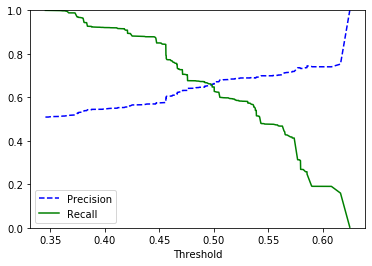

In [39]:
y_preb_prob = rf_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_preb_prob)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

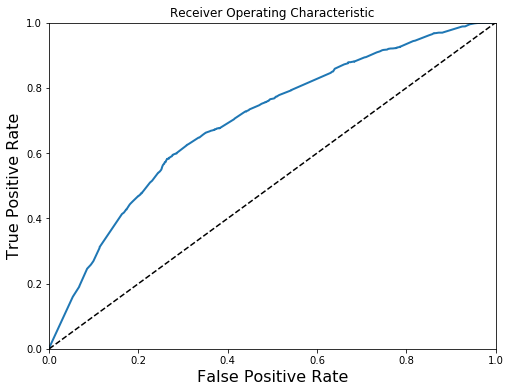

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preb_prob)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

### Undersample the majority class with original dataset

In [41]:
# orgininal dataframe
df_raw = df.loc[:, 'accountNumber':"isFraud"]
print("The shape of the original dataset: ", df_raw.shape)

# drop unwanted columns
df_clean = df_raw.drop(columns=[
    'accountNumber', 'customerId', 'transactionDateTime', 'currentExpDate',
    'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV',
    'cardLast4Digits', 'merchantName'
])
print("After dropping unwanted columns, the shape is ", df_clean.shape)

# drop records with missing values
df_clean = df_clean.dropna(0)
print("After dropping the rows with missing values, the shape is ", df_clean.shape)

# Fraud subset
df_clean_fraud = df_clean[df_clean['isFraud']]
print("The shape of fraud subset: ", df_clean_fraud.shape)

# Non-fraud subset
df_clean_non_fraud = df_clean[~ df_clean['isFraud']]
print("The shape of non-fraud subset: ", df_clean_non_fraud.shape)

# resample from the non-fradu subset
df_clean_non_fraud_resample = df_clean_non_fraud.sample(n=len(df_clean_fraud), replace=False, random_state=42)
print("The shape of resampled non-fraud subset: ", df_clean_non_fraud_resample.shape)

# balanced dataset 2
df_balanced_2 = pd.concat([df_clean_fraud, df_clean_non_fraud_resample])
print("After undersampling the majority class, the shape is ", df_balanced_2.shape)

The shape of the original dataset:  (786363, 23)
After dropping unwanted columns, the shape is  (786363, 13)
After dropping the rows with missing values, the shape is  (776668, 13)
The shape of fraud subset:  (11966, 13)
The shape of non-fraud subset:  (764702, 13)
The shape of resampled non-fraud subset:  (11966, 13)
After undersampling the majority class, the shape is  (23932, 13)


In [42]:
# the columns with object and category dtypes
df_balanced_2_cat = df_balanced_2.select_dtypes(['object', 'category'])

# get dummies
ohe = OneHotEncoder()
ohe_df_balanced_2_cat = ohe.fit_transform(df_balanced_2_cat)

# feature names of cat columns
ohe_df_balanced_2_cat_cols = ohe.get_feature_names(df_balanced_2_cat.columns)

# num cols of the df_balanced_2
df_balanced_2_num = df_balanced_2.drop(columns='isFraud').select_dtypes(['number', 'bool'])

# np array of df_balanced_2_num
df_balanced_2_num_val = df_balanced_2_num.values

# col names of df_balanced_2_num
df_balanced_2_num_cols = df_balanced_2_num.columns

# concatenate cat and num values as X
X = np.c_[ohe_df_balanced_2_cat.toarray(), df_balanced_2_num_val]

# save the feature names of X
X_feat = list(ohe_df_balanced_2_cat_cols) + list(df_balanced_2_num_cols)

# 
y=df_balanced_2.isFraud.values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16752, 44) (16752,)
(7180, 44) (7180,)


In [44]:
param_grid = {'n_estimators': [200, 500], 'max_depth':[2, 3]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, scoring ='neg_log_loss')
grid.fit(X_train, y_train)
print(grid.best_params_)

RFC =  RandomForestClassifier(**grid.best_params_)

RFC.fit(X_train, y_train)

{'max_depth': 3, 'n_estimators': 200}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
for col, importance in sorted(zip(X_feat, RFC.feature_importances_), key = lambda x: -abs(x[1])):
    print("feature name: %45s, coefficient: %10.6f" % (col, importance))

feature name:                             transactionAmount, coefficient:   0.306060
feature name:                               posEntryMode_05, coefficient:   0.194710
feature name:                                   cardPresent, coefficient:   0.119166
feature name:                               posEntryMode_09, coefficient:   0.088188
feature name:                     merchantCategoryCode_fuel, coefficient:   0.058880
feature name:            merchantCategoryCode_online_retail, coefficient:   0.053450
feature name:                 merchantCategoryCode_fastfood, coefficient:   0.030515
feature name:               merchantCategoryCode_mobileapps, coefficient:   0.029470
feature name:     merchantCategoryCode_online_subscriptions, coefficient:   0.015877
feature name:                   merchantCategoryCode_health, coefficient:   0.014435
feature name:            merchantCategoryCode_food_delivery, coefficient:   0.011457
feature name:                  merchantCategoryCode_airline, coef

In [46]:
y_preb = RFC.predict(X_test)
print("Accuracy", round(metrics.accuracy_score(y_test, y_preb) * 100, 2),"%")

Accuracy 68.08 %


In [47]:
print("Precision", round(metrics.precision_score(y_test, y_preb) * 100, 2),"%")
print("Recall", round(metrics.recall_score(y_test, y_preb) * 100, 2),"%")
print("f1 score", metrics.f1_score(y_test, y_preb))
print("R2 score", round(metrics.r2_score(y_test.astype(int), y_preb.astype(int)), 2))
print("confusion metrics\n", metrics.confusion_matrix(y_test, y_preb))

Precision 67.49 %
Recall 68.55 %
f1 score 0.6801562936087079
R2 score -0.28
confusion metrics
 [[2451 1174]
 [1118 2437]]


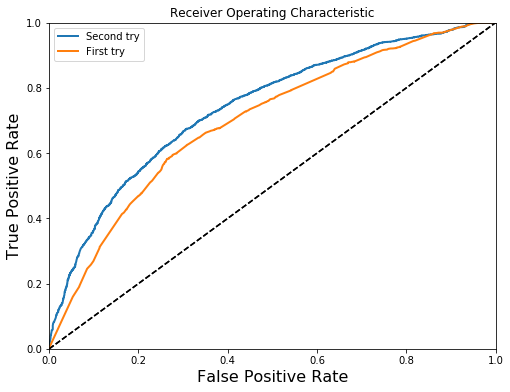

In [48]:
y_preb_prob_2 = RFC.predict_proba(X_test)[:, 1]
fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test, y_preb_prob_2)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_2, tpr_2, label='Second try')
plot_roc_curve(fpr, tpr, label='First try')
plt.legend()
plt.show()

### more hyperparameters

In [49]:
param_grid = {'n_estimators': [200, 300, 400, 500], 'max_depth':[3, 4, 5, 6]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, scoring ='neg_log_loss')
grid.fit(X_train, y_train)
print(grid.best_params_)

RFC =  RandomForestClassifier(**grid.best_params_)

RFC.fit(X_train, y_train)

{'max_depth': 6, 'n_estimators': 500}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
y_preb = RFC.predict(X_test)
print("Accuracy", round(metrics.accuracy_score(y_test, y_preb) * 100, 2),"%")
print("Precision", round(metrics.precision_score(y_test, y_preb) * 100, 2),"%")
print("Recall", round(metrics.recall_score(y_test, y_preb) * 100, 2),"%")
print("f1 score", metrics.f1_score(y_test, y_preb))
print("R2 score", round(metrics.r2_score(y_test.astype(int), y_preb.astype(int)), 2))
print("confusion metrics\n", metrics.confusion_matrix(y_test, y_preb))

Accuracy 68.68 %
Precision 68.63 %
Recall 67.68 %
f1 score 0.6814898739555305
R2 score -0.25
confusion metrics
 [[2525 1100]
 [1149 2406]]


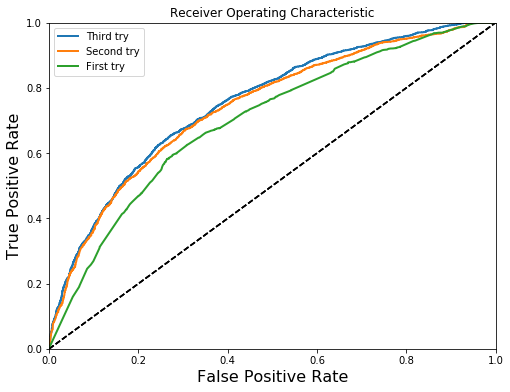

In [51]:
y_preb_prob_3 = RFC.predict_proba(X_test)[:, 1]
fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(y_test, y_preb_prob_3)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_3, tpr_3, label='Third try')
plot_roc_curve(fpr_2, tpr_2, label='Second try')
plot_roc_curve(fpr, tpr, label='First try')
plt.legend()
plt.show()